Dependencies installieren

In [1]:
 #@title Dependencies installieren
!pip install beautifulsoup4
!pip install lxml
!python -m spacy download de_core_news_lg
!pip install umap-learn
!pip install --upgrade gensim
!pip install unidecode
!pip install icecream

You should consider upgrading via the '/Users/jannis/opt/miniconda3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/Users/jannis/opt/miniconda3/bin/python -m pip install --upgrade pip' command.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 567.8/567.8 MB 6.0 MB/s eta 0:00:0000:0100:01
You should consider upgrading via the '/Users/jannis/opt/miniconda3/bin/python -m pip install --upgrade pip' command.
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_lg')


You should consider upgrading via the '/Users/jannis/opt/miniconda3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/Users/jannis/opt/miniconda3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/Users/jannis/opt/miniconda3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/Users/jannis/opt/miniconda3/bin/python -m pip install --upgrade pip' command.


Bibliotheken importieren

In [2]:
 #@title Bibliotheken importieren
from bs4 import BeautifulSoup
import urllib.request
import re
import spacy
import numpy as np
import umap
import matplotlib.pyplot as plt
from icecream import ic
import requests

nlp = spacy.load('de_core_news_lg')

/Users/jannis/opt/miniconda3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
 #@title Funktionsdefinitionen Artikeldownload
# download wikipedia article from url, return raw text
def get_article(url : str) -> str:
    scraped = requests.get(url)

    article = scraped.text

    parsed = BeautifulSoup(article, 'lxml')

    paragraphs = parsed.find_all('p')

    article_text = ""
    for p in paragraphs:
        article_text = ' '.join([article_text, p.text])
    return article_text


# preprocess text. Put everything to lowercase, remove punctuation with 
def preprocess_article(article : str):
    lower = article.lower()
    #unidec = unidecode.unidecode(lower)
    no_punct = re.sub('[^a-zA-ZäöüÄÖÜß]', ' ', lower)
    final = re.sub(r'\s+', ' ', no_punct)
    return final

## Es werden jeweils 11 Artikel zum Thema Baumarkt/Einzelhandel und 11 Artikel zum Thema Regierung heruntergeladen und entsprechend getaggt

In [4]:
# what articles to download?
base_url = "https://de.wikipedia.org/wiki/" # base url for wikipedia
# list of articles, 11 articles concerning government/politics
# and 11 articles concerning shops
articles = [
                "Baumarkt", "toom_Baumarkt", "Do_it_yourself",
                "Bauhaus_(Baumarkt)", "Obi_(Baumarkt)", "Hagebau",
                "Hornbach_(Baumarkt)", "Einzelhandel", "IKEA",
                "Gartencenter", "Rewe_Group",
                "König", "Kaiser", "Tenno", "Staatspräsident",
                "Bundeskanzler_(Deutschland)", "Republik", "Monarchie",
                "Europäische_Union", "Herzog", "Fürst", "Demokratie"
            ]
# list of topics for each article
article_topic = ["Einzelhandel"]*11 + ['Regierung']*11

# list with article raw texts
article_texts = [get_article(base_url + article) for article in articles]

In [5]:
 #@title Artikel Preprocessing

preprocessed = [preprocess_article(art) for art in article_texts]

# create spacy document for each preprocessed article
docs = [nlp(art) for art in preprocessed]

# create learning dataset for word2vec
words = [
         [
          word.lemma_ for word in doc if ((not word.is_stop) and (len(word)>=3))
          ]
         for doc in docs
         ]

## Die Artikel werden genutzt, um das Sprachlernmodell zu trainieren

In [6]:
 #@title Trainiere Word2Vec

from gensim.models import Word2Vec

# Create Word2Vec Model
word2vec = Word2Vec(words, min_count=3, sg=1, hs=0, negative=9, ns_exponent=0.69, window=10, vector_size=60, epochs=80)

# train word2vec model
word2vec.train(words, total_examples=word2vec.corpus_count, epochs=word2vec.epochs)

(2072056, 3009200)

In [7]:
 #@title Wortähnlichkeiten
print('Word Similarities:')
print('toom, Baumarkt: ', word2vec.wv.similarity('Toom', 'Baumarkt'))
print('König, Königin: ', word2vec.wv.similarity('König', 'Königin'))
print('König, Herzog: ', word2vec.wv.similarity('König', 'Herzog'))
print('König, Kaiser: ', word2vec.wv.similarity('König', 'Kaiser'))
print('####')
print('toom, König: ', word2vec.wv.similarity('Toom', 'König'))

Word Similarities:
toom, Baumarkt:  0.8884885
König, Königin:  0.537671
König, Herzog:  0.41603833
König, Kaiser:  0.7039684
####
toom, König:  0.23786725


In [8]:
 #@title Ähnlichste Worte zu Baumarkt
worte = word2vec.wv.most_similar(positive=['Baumarkt'])
worte

[('Toom', 0.8884884119033813),
 ('Group', 0.7934972643852234),
 ('Rewe', 0.7530603408813477),
 ('Baumärkt', 0.7341711521148682),
 ('märkte', 0.7270146012306213),
 ('Kette', 0.7261427044868469),
 ('Marke', 0.7069173455238342),
 ('Unternehmen', 0.7050850987434387),
 ('Klee', 0.7044740915298462),
 ('Gartencenter', 0.6967099905014038)]

In [9]:
 #@title Ähnlichste Worte zu Bundeskanzler + Frau
word2vec.wv.most_similar(positive=['Bundeskanzler', 'Frau'], negative=[], topn=5)

[('Merkel', 0.7603102326393127),
 ('Bundeskanzlerin', 0.7343284487724304),
 ('Bundestag', 0.7213973999023438),
 ('Grundgesetz', 0.6999688744544983),
 ('Bundesregierung', 0.6841852068901062)]

In [10]:
 #@title Ähnlichste Worte zu Kaiser + russisch - Deutschland
word2vec.wv.most_similar(positive=['Kaiser', 'russisch', 'Russland'], negative=['Deutschland'], topn=5)

[('zaren', 0.6550924777984619),
 ('Byzanz', 0.6164711713790894),
 ('Zar', 0.6069549918174744),
 ('Rhomäer', 0.604256272315979),
 ('Mächt', 0.5861892700195312)]

In [11]:
 #@title Ähnlichste Worte zu Kaiser + japanisch - Deutschland
word2vec.wv.most_similar(positive=['Kaiser', 'japanisch'], negative=['Deutschland'], topn=5)

[('Tenn', 0.6677154898643494),
 ('Kaisertum', 0.6231889128684998),
 ('Herrscher', 0.59166020154953),
 ('Jahrhundert', 0.577750563621521),
 ('Kaiserreich', 0.5705031752586365)]

In [12]:
#@title Zuordnung Wörter zu Artikelthema

# Dictionary holding topic for each word in vocabulary by assigned word to topic
# based on which article the word appears in most often
topic_dict = {}
for word in word2vec.wv.index_to_key:
    topic = article_topic[np.argmax([art.count(word.lower()) for art in preprocessed])]
    topic_dict[word] = topic

topic_dict

{'europäisch': 'Regierung',
 'Demokratie': 'Regierung',
 'Kaiser': 'Regierung',
 'Bundeskanzler': 'Regierung',
 'Staat': 'Regierung',
 'politisch': 'Regierung',
 'deutsch': 'Regierung',
 'Ikea': 'Einzelhandel',
 'König': 'Regierung',
 'Union': 'Regierung',
 'Deutschland': 'Regierung',
 'Rewe': 'Einzelhandel',
 'Titel': 'Regierung',
 'Art': 'Regierung',
 'führen': 'Regierung',
 'Republik': 'Regierung',
 'Regierung': 'Regierung',
 'römisch': 'Regierung',
 'Land': 'Regierung',
 'Mitgliedstaat': 'Regierung',
 'gemeinsam': 'Regierung',
 'demokratisch': 'Regierung',
 'Volk': 'Regierung',
 'Parlament': 'Regierung',
 'stark': 'Regierung',
 'System': 'Regierung',
 'gelten': 'Regierung',
 'Unternehmen': 'Einzelhandel',
 'stellen': 'Regierung',
 'bezeichnen': 'Regierung',
 'Wahl': 'Regierung',
 'Bundestag': 'Regierung',
 'Mitglied': 'Regierung',
 'hoch': 'Regierung',
 'stehen': 'Regierung',
 'wählen': 'Regierung',
 'Monarchie': 'Regierung',
 'Jahrhundert': 'Regierung',
 'Fürst': 'Regierung',
 'Eu

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


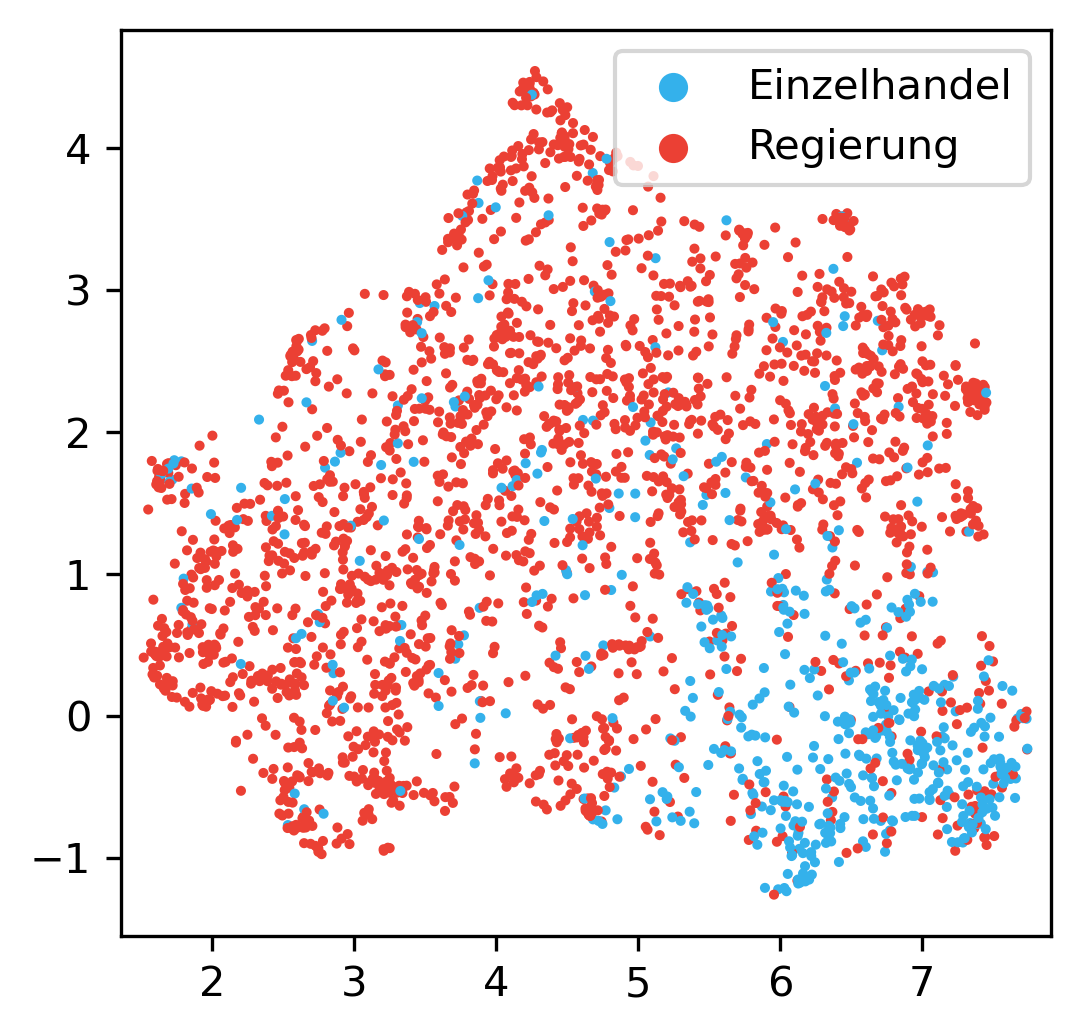

In [13]:
#@title Darstellung Wortvektor vs Artikelzuordnung
# Define umap projection
reducer = umap.UMAP(metric='cosine', n_components=2, n_neighbors=15, min_dist=0.00, random_state=0)

# X holds the word vectors for all words in vocabulary
X = word2vec.syn1neg

embedding = reducer.fit_transform(X[:,:])

# plot projected word vectors
plt.figure(figsize=(4,4), dpi=300)
# scatterplot of projected word vectors
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c = ['#eb4034' if topic=='Regierung' else '#34b1eb' for topic in list(topic_dict.values())[:]],
    s = 2
    )
# used for generating legend only
for color in ['#34b1eb', '#eb4034']:
    lbl = 'Regierung' if color=='#eb4034' else 'Einzelhandel'
    plt.scatter([],[],color=color, label=lbl)
plt.legend()
plt.gca().set_aspect('equal', 'datalim')

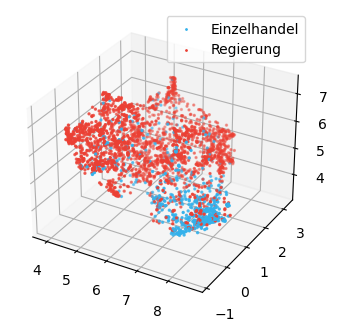

In [14]:
#@title Darstellung Wortvektor vs Themenzuordnung 3D
# Project into 3D space
reducer3D = umap.UMAP(metric='cosine', n_components=3, n_neighbors=15, min_dist=0.00, random_state=0)
embedding3D = reducer3D.fit_transform(X[:,:])

# plot in 3D and create animation (rotate space)
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(4,4), dpi=100)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(
    embedding3D[:, 0],
    embedding3D[:, 1],
    embedding3D[:, 2],
    c = ['#eb4034' if topic=='Regierung' else '#34b1eb' for topic in list(topic_dict.values())[:]],
    s = 2
    )
for color in ['#34b1eb', '#eb4034']:
    lbl = 'Regierung' if color=='#eb4034' else 'Einzelhandel'
    plt.scatter([],[], [], color=color, label=lbl)
plt.legend()

def rotate(angle):
    ax.view_init(azim=angle)

rot_animation = animation.FuncAnimation(fig, rotate, frames=np.arange(0, 362,10), repeat=True)

In [15]:
#@title 3D Animation
# embed animation on page
from matplotlib import rc
rc('animation', html='jshtml')

rot_animation

In [16]:
#@title Artikelvektorenzuordnung Funktionen

# calculate center of mass vector for list of words (used here for article as
# collection of words)
def get_com_vector(words : list) -> np.array:
    words = [word for word in words if word in word2vec.wv.index_to_key]
    vectors = np.array([word2vec.wv.get_vector(word) for word in words])
    vector = np.sum(vectors, axis=0)
    return vector / len(words)

# get vector for each article
article_vectors = []
for article_words in words:
    vec = get_com_vector(article_words)
    article_vectors.append(vec)

# calculate cosine similartiy
def cos_sim(vec0: np.array, vec1: np.array) -> float:
    return np.dot(vec0, vec1)/(np.linalg.norm(vec0)*np.linalg.norm(vec1))

# classify a vector by comparing cosine similarity to known article vectors
def classify_article(article_vectors: np.array, new_article_vector: np.array):

    # split article vectors into articles concerning government and
    # physics topics
    article_vectors_government = [
                                  article_vectors[i]
                                  for i in range(len(article_vectors))
                                  if (article_topic[i]=='Einzelhandel')
                                ]

    article_vectors_physics = [
                               article_vectors[i]
                               for i in range(len(article_vectors))
                               if (article_topic[i]=='Regierung')
                            ]
    # calculate similarities between new_article_vector and known
    # article_vectors for both categories
    sims_gov = [
                    cos_sim(new_article_vector, av)
                    for av in article_vectors_government
                ]
    sims_phys = [
                    cos_sim(new_article_vector, av)
                    for av in article_vectors_physics
                 ]
    # calculate avg similarities
    sims = [np.sum(sims_gov)/len(sims_gov), np.sum(sims_phys)/len(sims_phys)]

    # choose topic with higher similarity
    j = np.argmax(sims)
    topic = ["Einzelhandel", "Regierung"][j]

    return topic, sims

# download new article, preprocess
def new_article_vector(article: str) -> np.array:
    # get new article
    article_new = get_article(base_url + article)

    # preprocess new article
    prep_new = preprocess_article(article_new)

    # create spacy doc and remove stopwords
    doc_new = nlp(prep_new)

    words_new = [
                    word.lemma_ for word in doc_new
                    if (not word.is_stop) and (len(word)>2)
                 ]

    # calculate vector for new article
    new_article_vector = get_com_vector(words_new)

    return new_article_vector

def new_text_vector(text : str):
    prep_new = preprocess_article(text)
    doc_new = nlp(prep_new)

    words_new = [
                    word.lemma_ for word in doc_new
                    if (not word.is_stop) and (len(word)>2)
                 ]

    # calculate vector for new article
    new_article_vector = get_com_vector(words_new)

    return new_article_vector

In [17]:
classify_article(article_vectors, new_article_vector('Hagebau_(Baumarkt)'))

('Einzelhandel', [0.7627411755648527, 0.6550148183649237])

In [18]:
classify_article(article_vectors, new_article_vector('Home_Depot'))

('Einzelhandel', [0.8028345108032227, 0.6321761391379617])

In [19]:
classify_article(article_vectors, new_article_vector('Zar'))

('Regierung', [0.5776386260986328, 0.802034464749423])

In [20]:
classify_article(article_vectors, new_text_vector('Wir haben unser Jahresziel erreicht und können beruhigt auf das nächste Geschäftsjahr schauen.'))

('Einzelhandel', [0.6252686760642312, 0.49255678870461206])

In [21]:
classify_article(article_vectors, new_text_vector('Der neue Golf GTI erscheint am 26. September.'))

('Einzelhandel', [0.5139601880853827, 0.4157977971163663])

In [22]:
classify_article(article_vectors, new_text_vector('Die Verwaltungsreform bringt viele Erleichterungen für die Bürger.'))

('Regierung', [0.35392663695595483, 0.48291739550503815])